In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as random
import jax.scipy as jsp
from minigp.gp import *
from minigp.kernel import DeepKernelParameters, DeepKernel
from minigp.utils import *

In [2]:
def warp(x: jnp.ndarray) -> jnp.ndarray:
    """Warping function that maps [0, 24pi] to [0, 12pi], with non-linear squeezing."""
    # Define boundaries
    segment1 = 4 * jnp.pi
    segment2 = 8 * jnp.pi
    max_x = 12 * jnp.pi

    # Define corresponding warped boundaries
    warped_segment1 = 16 * jnp.pi
    warped_segment2 = 18 * jnp.pi
    max_warped = 34 * jnp.pi

    # Apply piecewise transformation
    warped_x = jnp.where(x <= segment1,
                         x * (warped_segment1 / segment1),  # Squeeze the first segment
                         jnp.where(x <= segment2,
                                   (x - segment1) * ((warped_segment2 - warped_segment1) / (segment2 - segment1)) + warped_segment1,  # Middle segment mostly unchanged
                                   (x - segment2) * ((max_warped - warped_segment2) / (max_x - segment2)) + warped_segment2  # Squeeze the last segment
                         ))
    return warped_x

def warped_sine(x: jnp.ndarray) -> jnp.ndarray:
    """Compute sine of the warped input."""
    warped_x = warp(x)
    return jnp.sin(warped_x)


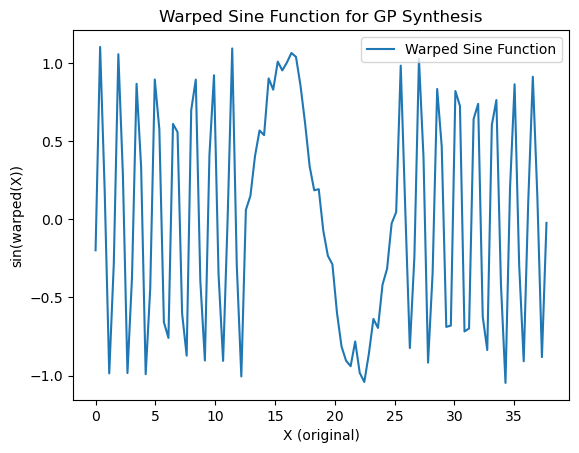

In [3]:
X_train = jnp.linspace(0, 12 * jnp.pi, 100).reshape(-1, 1) 
y_train = warped_sine(X_train.flatten()) + 0.1 * random.normal(jax.random.PRNGKey(0), (100,))

# Convert to NumPy for plotting
X_np = np.array(X_train)
y_np = np.array(y_train)

# Plot the warped sine function
plt.plot(X_np, y_np, label="Warped Sine Function")
plt.title("Warped Sine Function for GP Synthesis")
plt.xlabel("X (original)")
plt.ylabel("sin(warped(X))")
plt.legend()
plt.show()

In [4]:
layer_dims = [1, 10, 1]
key = jax.random.PRNGKey(0)

kernel = DeepKernel(net_fn=ResNetNN, layer_dims=layer_dims)
kernel_params = kernel.init_params(key)

gp = GaussianProcess()
state, gp_params = gp.init_state_with_params(kernel, kernel_params, X_train, y_train)

In [5]:
def flatten_params(kernel_params: DeepKernelParameters, gp_params: GaussianProcessParameters):
    """Flatten kernel and GP parameters into a dictionary."""
    params = {
        'sigma': kernel_params.sigma,
        'nn_params': kernel_params.nn_params,
        'noise': gp_params.noise
    }
    return params

Iteration 10, Loss: 151.1082
Iteration 20, Loss: 121.8975
Iteration 30, Loss: 106.2839
Iteration 40, Loss: 104.2437
Iteration 50, Loss: 104.6301
Iteration 60, Loss: 103.7945
Iteration 70, Loss: 102.9287
Iteration 80, Loss: 102.2320
Iteration 90, Loss: 101.3643
Iteration 100, Loss: 100.3678


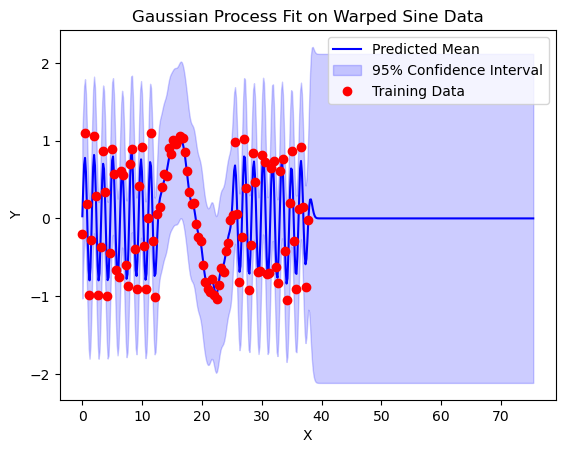

In [7]:
optimized_params = optimize_mle_nn(gp, state, kernel_params, gp_params)

optimized_kernel_params = DeepKernelParameters(sigma=optimized_params['sigma'], nn_params=optimized_params['nn_params'])
optimized_gp_params = GaussianProcessParameters(noise=optimized_params['noise'])

state, gp_params = gp.fit(state, optimized_kernel_params, optimized_gp_params)

X_test = jnp.linspace(0, 24 * jnp.pi, 500).reshape(-1, 1) 
mu_s, cov_s = gp.predict(state, optimized_kernel_params, optimized_gp_params, X_test)
std_s = jnp.sqrt(cov_s)

X_test_np = np.array(X_test)
mu_s_np = np.array(mu_s).flatten()
std_s_np = np.array(std_s)

plt.plot(X_test_np, mu_s_np, 'b-', label="Predicted Mean")
plt.fill_between(X_test_np.flatten(),
                 (mu_s_np - 1.96 * std_s_np).flatten(),
                 (mu_s_np + 1.96 * std_s_np).flatten(),
                 color='blue', alpha=0.2, label="95% Confidence Interval")
plt.plot(np.array(X_train), np.array(y_train), 'ro', label="Training Data")
plt.title("Gaussian Process Fit on Warped Sine Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()